# Language translation using transformer

We use a transformer architecture to build a German-to-English translator.

For details, see:
[Attention is all you need](https://papers.nips.cc/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf) and [The annotated transformer.](https://nlp.seas.harvard.edu/2018/04/03/attention.html#positional-encoding)

In [8]:
!pip install -U spacy
!python -m spacy download en_core_web_sm
!python -m spacy download de_core_news_sm

from typing import List, Dict, Tuple

import math
from collections import Counter
import matplotlib.pyplot as plt

import torchtext
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import vocab
from torchtext.vocab.vocab import Vocab
from torchtext.utils import download_from_url, extract_archive
import torch
import torch.nn as nn
from torch import Tensor
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
from torch.nn import (TransformerEncoder, 
                      TransformerDecoder,
                      TransformerEncoderLayer, 
                      TransformerDecoderLayer)

import io
import time

torch.manual_seed(0)
torch.use_deterministic_algorithms(False)

# Data processing

We load data, tokenize the raw sentences, build vocabularies for English and German, map sequence of tokens to tensors.

In [2]:
# download and extract data
url_base = 'https://raw.githubusercontent.com/multi30k/dataset/master/data/task1/raw/'
train_urls = ('train.de.gz', 'train.en.gz')
val_urls = ('val.de.gz', 'val.en.gz')
test_urls = ('test_2016_flickr.de.gz', 'test_2016_flickr.en.gz')

train_filepaths = [extract_archive(download_from_url(url_base + url))[0] for url in train_urls]
val_filepaths = [extract_archive(download_from_url(url_base + url))[0] for url in val_urls]
test_filepaths = [extract_archive(download_from_url(url_base + url))[0] for url in test_urls]

# get tokenizers, english and german
de_tokenizer = get_tokenizer('spacy', language='de_core_news_sm')
en_tokenizer = get_tokenizer('spacy', language='en_core_web_sm')

# Define special symbols and indices
UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3

def build_vocab(filepath: str, tokenizer) -> Vocab:
    """
    Build and return vocabulary object.
    """
    # ordered dictionary: tokens -> frequencies
    counter = Counter()
    with io.open(filepath, encoding="utf8") as f:
        for string_ in f:
            counter.update(tokenizer(string_))
    vocab_ = vocab(counter, specials=['<unk>', '<pad>', '<bos>', '<eos>'])
    vocab_.set_default_index(UNK_IDX)
    return vocab_

de_vocab = build_vocab(train_filepaths[0], de_tokenizer)
en_vocab = build_vocab(train_filepaths[1], en_tokenizer)

def data_process(filepaths: List[str]) -> List[Tuple[Tensor, Tensor]]:
    """
    Args:
        filepaths: list with file paths to german and english language data.
    Returns:
        data: List of data samples. Each sample is a tuple containing the
            english and german versions of the sentence. 
    """
    raw_de_iter = iter(io.open(filepaths[0], encoding="utf8"))
    raw_en_iter = iter(io.open(filepaths[1], encoding="utf8"))
    data = []
    for (raw_de, raw_en) in zip(raw_de_iter, raw_en_iter):
        # tokenize sentence, map tokens to indeces
        de_tensor_ = torch.tensor([de_vocab[token] for token in de_tokenizer(raw_de.rstrip("\n"))],
                            dtype=torch.long)
        en_tensor_ = torch.tensor([en_vocab[token] for token in en_tokenizer(raw_en.rstrip("\n"))],
                            dtype=torch.long)
        data.append((de_tensor_, en_tensor_))

    return data


def generate_batch(data_batch):
    """
    Adds beginning/end of sentence markers, and pads. Collate function
    for dataloaders.
    """
    de_batch, en_batch = [], []
    for (de_item, en_item) in data_batch:
        # append BOS and EOS indeces
        de_batch.append(torch.cat([torch.tensor([BOS_IDX]), de_item, torch.tensor([EOS_IDX])], dim=0))
        en_batch.append(torch.cat([torch.tensor([BOS_IDX]), en_item, torch.tensor([EOS_IDX])], dim=0))
    # pad so all sequences in the batch have same length
    de_batch = pad_sequence(de_batch, padding_value=PAD_IDX)
    en_batch = pad_sequence(en_batch, padding_value=PAD_IDX)

    return de_batch, en_batch


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE = 128

# datasets
train_data = data_process(train_filepaths)
val_data = data_process(val_filepaths)
test_data = data_process(test_filepaths)

# dataloaders
train_iter = DataLoader(train_data, batch_size=BATCH_SIZE,
                        shuffle=True, collate_fn=generate_batch)
valid_iter = DataLoader(val_data, batch_size=BATCH_SIZE,
                        shuffle=True, collate_fn=generate_batch)
test_iter = DataLoader(test_data, batch_size=BATCH_SIZE,
                       shuffle=True, collate_fn=generate_batch)


100%|██████████| 637k/637k [00:00<00:00, 74.9MB/s]
100%|██████████| 569k/569k [00:00<00:00, 89.6MB/s]
100%|██████████| 24.7k/24.7k [00:00<00:00, 12.9MB/s]
100%|██████████| 21.6k/21.6k [00:00<00:00, 6.10MB/s]
100%|██████████| 22.9k/22.9k [00:00<00:00, 17.5MB/s]
100%|██████████| 21.1k/21.1k [00:00<00:00, 5.69MB/s]


In [46]:
print(' '.join(de_vocab.lookup_tokens(train_data[0][0].tolist())))
print(' '.join(en_vocab.lookup_tokens(train_data[0][1].tolist())))

Zwei junge weiße Männer sind im Freien in der Nähe vieler Büsche .
Two young , White males are outside near many bushes .


# Architecture 

In [9]:
NHEAD = 8 # the number of heads in the multiheadattention models

class PositionalEncoding(nn.Module):
    """
    Computes positional encoding. The positional encoding is added to the token 
    embedding to introduce a notion of word order

    Args:
        emb_size: embedding dimension. The positional encodings have the same 
            dimension as the embeddings so that the two can be summed
    """
    def __init__(self, emb_size: int, dropout, maxlen: int = 5000):
        super().__init__()
        den = torch.exp(- torch.arange(0, emb_size, 2) * math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding: Tensor):
        return self.dropout(token_embedding +
                            self.pos_embedding[:token_embedding.size(0),:])

class TokenEmbedding(nn.Module):
    """
    Embeds index tensors to dense semantic represantion.
    
    Args:
        vocab_size: size of vocabulary.
        emb_size: embedding space dimension.
    """
    def __init__(self, vocab_size: int, emb_size) -> None:
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size

    def forward(self, tokens: Tensor) -> Tensor:
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)


class Seq2SeqTransformer(nn.Module):
    """
    Sequence-to-sequence translation architecture.

    num_encoder_layers: the number of sub-encoder-layers in the encoder.
    num_decoder_layers: the number of sub-decoder-layers in the decoder.
    emb_size: the number of expected dimensionality in the input (embedded).
    """
    def __init__(self, 
                 num_encoder_layers: int, 
                 num_decoder_layers: int,
                 emb_size: int, 
                 src_vocab_size: int, 
                 tgt_vocab_size: int,
                 dim_feedforward:int = 512, 
                 dropout:float = 0.1
                 ) -> None:

        super().__init__()
        encoder_layer = TransformerEncoderLayer(d_model=emb_size, 
                                                nhead=NHEAD,
                                                dim_feedforward=dim_feedforward
                                                )
        self.transformer_encoder = TransformerEncoder(encoder_layer, 
                                                      num_layers=num_encoder_layers)
        decoder_layer = TransformerDecoderLayer(d_model=emb_size, 
                                                nhead=NHEAD,
                                                dim_feedforward=dim_feedforward)
        self.transformer_decoder = TransformerDecoder(decoder_layer, 
                                                      num_layers=num_decoder_layers)
        self.generator = nn.Linear(emb_size, tgt_vocab_size)
        self.src_tok_emb = TokenEmbedding(src_vocab_size, emb_size)
        self.tgt_tok_emb = TokenEmbedding(tgt_vocab_size, emb_size)
        self.positional_encoding = PositionalEncoding(emb_size, dropout=dropout)

    def forward(self, 
                src: Tensor, 
                trg: Tensor, 
                src_mask: Tensor,
                tgt_mask: Tensor, 
                src_padding_mask: Tensor,
                tgt_padding_mask: Tensor, 
                memory_key_padding_mask: Tensor):
        
        # embed and positional encode, source and target
        src_emb = self.positional_encoding(self.src_tok_emb(src))
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(trg))
        # encoder pass for the source
        memory = self.transformer_encoder(src_emb, 
                                          src_mask, 
                                          src_padding_mask)
        # decoder using memory and target
        outs = self.transformer_decoder(tgt_emb, memory, tgt_mask, 
                                        memory_mask=None,
                                        tgt_key_padding_mask=tgt_padding_mask, 
                                        memory_key_padding_mask=memory_key_padding_mask)
        return self.generator(outs)

    def encode(self, src: Tensor, src_mask: Tensor):
        return self.transformer_encoder(self.positional_encoding(
                            self.src_tok_emb(src)), src_mask)

    def decode(self, tgt: Tensor, memory: Tensor, tgt_mask: Tensor):
        return self.transformer_decoder(self.positional_encoding(
                          self.tgt_tok_emb(tgt)), memory,
                          tgt_mask)

In [4]:
def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones((sz, sz), device=device)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

def create_mask(src, tgt):
    src_seq_len = src.shape[0]
    tgt_seq_len = tgt.shape[0]

    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
    src_mask = torch.zeros((src_seq_len, src_seq_len), device=device).type(torch.bool)

    src_padding_mask = (src == PAD_IDX).transpose(0, 1)
    tgt_padding_mask = (tgt == PAD_IDX).transpose(0, 1)
    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

# Model

In [40]:
BATCH_SIZE = 128
NUM_EPOCHS = 13

transformer = Seq2SeqTransformer(
    num_encoder_layers = 3, 
    num_decoder_layers = 3,
    emb_size = 512, 
    src_vocab_size = len(de_vocab), 
    tgt_vocab_size = len(en_vocab),
    dim_feedforward = 512
    ) 

for p in transformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

transformer = transformer.to(device)

loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)

optimizer = torch.optim.Adam(
    transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9
)

# Training and eval functions

We define the training step excluding the source mask so that the encoder applies full attention to the source sentence. We do pass a target mask to avoid attending to future tokens in the training target sentence.

In [39]:
def train_epoch(model, train_iter, optimizer):
  model.train()
  losses = 0
  for idx, (src, tgt) in enumerate(train_iter):
      src = src.to(device)
      tgt = tgt.to(device)

      tgt_input = tgt[:-1, :]
      _, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)
      logits = model(src,
                     tgt_input, 
                     None, # source mask
                     tgt_mask,
                     src_padding_mask, 
                     tgt_padding_mask, 
                     src_padding_mask)
      
      optimizer.zero_grad()

      tgt_out = tgt[1:,:]
      loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
      loss.backward()

      optimizer.step()
      losses += loss.item()
  return losses / len(train_iter)

def evaluate(model, val_iter):
    model.eval()
    losses = 0
    for idx, (src, tgt) in (enumerate(valid_iter)):
        src = src.to(device)
        tgt = tgt.to(device)

        tgt_input = tgt[:-1, :]

        _, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        logits = model(src, 
                       tgt_input, 
                       None, # source mask
                       tgt_mask,
                       src_padding_mask, 
                       tgt_padding_mask, 
                       src_padding_mask)
        tgt_out = tgt[1:,:]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        losses += loss.item()
    return losses / len(val_iter)

### Training loop

In [41]:
train_losses, val_losses = [], []

for epoch in range(1, NUM_EPOCHS+1):
    start_time = time.time()
    train_loss = train_epoch(transformer, train_iter, optimizer)
    end_time = time.time()
    val_loss = evaluate(transformer, valid_iter)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, "
          f"Epoch time = {(end_time - start_time):.3f}s"))

Epoch: 1, Train loss: 5.343, Val loss: 4.091, Epoch time = 33.444s
Epoch: 2, Train loss: 3.732, Val loss: 3.269, Epoch time = 34.083s
Epoch: 3, Train loss: 3.129, Val loss: 2.856, Epoch time = 34.320s
Epoch: 4, Train loss: 2.737, Val loss: 2.593, Epoch time = 34.543s
Epoch: 5, Train loss: 2.445, Val loss: 2.415, Epoch time = 34.804s
Epoch: 6, Train loss: 2.215, Val loss: 2.276, Epoch time = 35.327s
Epoch: 7, Train loss: 2.023, Val loss: 2.161, Epoch time = 35.671s
Epoch: 8, Train loss: 1.858, Val loss: 2.093, Epoch time = 35.620s
Epoch: 9, Train loss: 1.717, Val loss: 2.023, Epoch time = 35.568s
Epoch: 10, Train loss: 1.591, Val loss: 1.998, Epoch time = 35.684s
Epoch: 11, Train loss: 1.482, Val loss: 1.952, Epoch time = 35.746s
Epoch: 12, Train loss: 1.382, Val loss: 1.928, Epoch time = 35.735s
Epoch: 13, Train loss: 1.292, Val loss: 1.895, Epoch time = 35.788s


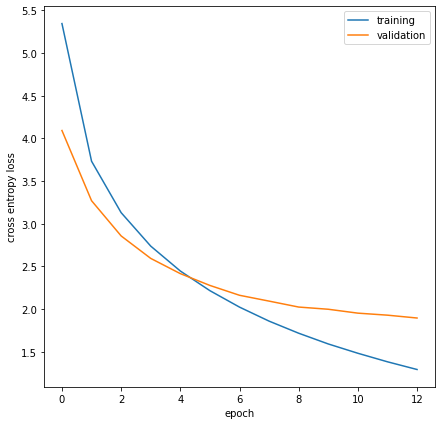

In [57]:
plt.figure(figsize=(7,7))
plt.plot(range(len(train_losses)), train_losses,label='training' )
plt.plot(range(len(val_losses)), val_losses,label='validation' )
plt.legend()
plt.xlabel('epoch')
plt.ylabel('cross entropy loss')
plt.show()

Note that there is some overfitting with current model + data combination.

# Inference

We collect methods to translate and show examples.

In [53]:
def greedy_decode(model, src, src_mask, max_len, start_symbol=BOS_IDX):
    """
    Helper function which greedily predicts next token given previous 
    predictions.

    Args:
        model: transformer model for sequence-to-sequence translation.
        src: input sentence to translate.
        src_mask: source mask.
        max_len: maximum length of predicted sentence.
        start_symbol: starting token in predicted sentence. By default the
            constant BOS_IDX.

    Returns:
        ys: predicted senquence of tokens.
    """
    src = src.to(device)
    
    if src_mask is not None: src_mask = src_mask.to(device)

    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(device)
    for i in range(max_len-1):
        memory = memory.to(device)
        memory_mask = torch.zeros(ys.shape[0], memory.shape[0]).to(device).type(torch.bool)
        tgt_mask = (generate_square_subsequent_mask(ys.size(0))
                                    .type(torch.bool)).to(device)
        out = model.decode(ys, memory, tgt_mask)
        out = out.transpose(0, 1)
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim = 1)
        next_word = next_word.item()

        ys = torch.cat(
            [ys, torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=0)
        if next_word == EOS_IDX:
          break
    return ys


def translate(model: Seq2SeqTransformer, 
              src: str, 
              src_vocab: Vocab, 
              tgt_vocab: Vocab, 
              src_tokenizer) -> str:
    """
    Translates source sentence using transformer.

    Args:
        model: transformer model for sequence-to-sequence translation.
        src: input sentence to translate.
        src_vocab: source torchtext vocabulary object.
        tgt_vocab: target torchtext vocabulary object.
        src_tokenizer: source tokenizer.

    Returns:
        translated version of input sentence.
    """
    model.eval()
    tokens = [BOS_IDX] + [src_vocab.get_stoi()[tok] for tok in src_tokenizer(src)]+ [EOS_IDX]
    num_tokens = len(tokens)
    src = (torch.LongTensor(tokens).reshape(num_tokens, 1) )
    # Just as during training, we do not apply a source mask, instead we 
    # pass None
    tgt_tokens = greedy_decode(model, 
                               src, 
                               src_mask=None, 
                               max_len=num_tokens + 5, 
                               start_symbol=BOS_IDX).flatten()
    return " ".join(
        [tgt_vocab.get_itos()[tok] for tok in tgt_tokens]
        ).replace("<bos>", "").replace("<eos>", "")

In [47]:
translate(transformer, "Eine Gruppe von Menschen steht vor einem Iglu .", 
          de_vocab, en_vocab, de_tokenizer)

' A group of people standing in front of an auditorium . '

In [54]:
translate(transformer, "Die Autos fahren schnell", 
          de_vocab, en_vocab, de_tokenizer)

' The cars are racing up . '